<a href="https://colab.research.google.com/github/jackmizell12/NeuroMatch-2020-Capstone-Project/blob/main/JM_Corgis_load_steinmetz_decisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

includes some visualizations

In [ ]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [ ]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


# I. Data Prep
Remove no-go data and establish lists of session information for later querying

In [ ]:
dat_wo_nogo = [] 
brainAreas = [] 
rightContrast = []
leftContrast = []
responses = []
actions = []

for i in range(len(alldat)):

  # Get spike data per session and remove no-go trials
  dat = alldat[i]
  trials_wo_nogo = (dat['contrast_right'] > 0) | (dat['contrast_left'] > 0)
  dat_wo_nogo.append(dat['spks'][:, trials_wo_nogo, :])

  # Get response data per session (correct vs incorrect)
  responses.append(dat['feedback_type'][trials_wo_nogo])

  # Get brain area per session
  brainAreas.append(dat['brain_area'])

  # Get contrast level for per side
  rightContrast.append(dat['contrast_right'][trials_wo_nogo])
  leftContrast.append(dat['contrast_left'][trials_wo_nogo])

  # Get mouse action per session (left vs right vs no-go)
  actions.append(dat['response'][trials_wo_nogo])

-`dat_wo_nogo`: list of spike data for each session without No-Go trials in shape Neurons x Trials x Time Bins

-`responses`: list of responses given to the mouse after each trial for each session in length Trials

-`brainAreas`: list of brain areas for each session as the location of each recorded neuron (VISp, VISam, MO etc) in length Neurons

Group specific brain areas (such as VISa and VISam) into more general brain regions (such as the visual cortex) for querying


In [ ]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

In [ ]:
# create a dictionary (map) for each brain location
maps = {} 
for i, r in enumerate(brain_groups): 
  for b in r: 
    maps[b] = i # assign each brain location to a number dictated by brain_groups list
maps['root'] = 8 # i gave the lil guy a number (8) since he wasn't in brain_groups (makes sense)

In [ ]:
# create a list of brain regions for each session where the visual cortex is 1, thalamus is 2 etc
brainRegions = []
for i in range(len(brainAreas)):
  brainRegions.append(np.array([maps[area] for area in brainAreas[i]])) # apply dictionary established earlier

Return sessions that contain recordings from certain brain areas of interest

In [ ]:
loc_ofInterest = ['VISp', 'CA3'] # which specific brain locations to query for
sessions_ofInterest = [] # list of sessions (0-38) including all the locations of interest

for sessionNumber, recordingLocations in enumerate(brainAreas):
  if all(x in recordingLocations for x in loc_ofInterest):
    sessions_ofInterest.append(sessionNumber)

sessions_ofInterest

[0, 7]

Pull spiking data from all mice and separate by trial type

In [ ]:
rightHit = []
rightMiss = []
leftHit = []
leftMiss = []

leftMiss_nogo = []
leftMiss_right = []
rightMiss_nogo = []
rightMiss_left = []

for i in range(len(dat_wo_nogo)):

  dat = dat_wo_nogo[i]

  # Subset trials
  rightHit.append(dat[:, (rightContrast[i] > leftContrast[i]) & (responses[i] == 1)])
  rightMiss.append(dat[:, (rightContrast[i] > leftContrast[i]) & (responses[i] == -1)])
  leftHit.append(dat[:, (rightContrast[i] < leftContrast[i]) & (responses[i] == 1)])
  leftMiss.append(dat[:, (rightContrast[i] < leftContrast[i]) & (responses[i] == -1)])

  leftMiss_nogo.append(dat[:, (rightContrast[i] < leftContrast[i]) & (actions[i] == 0)])
  leftMiss_right.append(dat[:, (rightContrast[i] < leftContrast[i]) & (actions[i] == -1)])
  rightMiss_nogo.append(dat[:, (rightContrast[i] > leftContrast[i]) & (actions[i] == 0)])
  rightMiss_left.append(dat[:, (rightContrast[i] > leftContrast[i]) & (actions[i] == 1)])

Which sessions contain data from the visual cortex, forebrain, and midbrain? 

In [ ]:
sessions_w_visForeMid = []
visForeMid=[0,3,4] #index for vis, mid, forebrain in the brainRegions
for i in range(len(brainRegions)):
  if all(x in brainRegions[i] for x in visForeMid):
    sessions_w_visForeMid.append(i)

sessions_w_visForeMid

[12, 13, 21, 23, 24, 25, 27, 35, 36]

# II. Analysis

How many neurons are in the visual cortex, forebrain, and midbrain regions per session?

In [ ]:
visN = []
for session in sessions_w_visForeMid:
  visN.append(np.sum(brainRegions[session] == 0))

foreN = []
for session in sessions_w_visForeMid:
  foreN.append(np.sum(brainRegions[session] == 3))

midN = []
for session in sessions_w_visForeMid:
  midN.append(np.sum(brainRegions[session] == 4))

In [ ]:
import pandas as pd

neuronCounts = pd.DataFrame({"session": sessions_w_visForeMid, "visual cortex count": visN, "forebrain count": foreN, "midbrain count": midN})
neuronCounts.set_index('session', inplace=True)
neuronCounts

,visual cortex count,forebrain count,midbrain count
session,,,
12,34,288,264
13,42,441,171
21,133,237,184
23,296,181,530
24,94,375,404
25,162,166,407
27,71,135,206
35,53,162,168
36,77,415,535


We want to run PCAs on spiking data for neurons in the visual cortex, forebrain, and midbrain.

In [ ]:
visForeMid = [0, 3, 4] # indeces for visual, forebrain (sans vis), and midbrain respectively
visFore = [0, 3]
visMid = [0, 4]
foreMid = [3, 4]
vis = [0]
fore = [3]
mid = [4]

trialTypes = [rightHit, rightMiss, leftHit, leftMiss]

### PCA Functions

In [ ]:
def get_dat_mult_regions(session, trialType, regions, time = 51:75):
  '''
  Stacked spike data from multiple regions of interest for the same mouse for use in PCA.

  Inputs:
  session (int): index that corresponds to session number
  trialType: rightHit, rightMiss, leftHit, leftMiss
  regions: visForeMid, visFore, visMid, foreMid

  Output:
  dataStack (array): spike data
  '''

  data = []

  for j in range(len(regions)):
    data.append(trialType[session][:, :, time][brainRegions[session] == regions[j]])

  dataStack = np.vstack(data)

  return dataStack

In [ ]:
from sklearn.decomposition import PCA

def generatePCA(session, regions = None, varThreshold = 0.95, single_region = False, structure = None):
  '''
  Inputs:
  session (int):        index that corresponds to session number
  regions (var):        visForeMid, visFore, visMid, foreMid
  varThreshold (float): desired cumulative percent of variance explained
  single_region (bool): set to true if comparing structures within a single region
  structure (var):      if single_region == True, set structure = structure
                          and loop through structures in desired cortical region

  Outputs:
  Each list outputs data for rightHit, rightMiss, leftHit, and leftMiss respectively
  numComp (list):       number of components needed to explain up to varThreshold
  percent (list):       percent of components needed to explain up to varThreshold
  components (list):    components matrix
  '''
  n_comp = []
  percent = [] 
  components = []

  for trial in trialTypes:
    if single_region:
      dat = trial[session][brainAreas[session] == structure]

    else:
      dat = get_dat_mult_regions(session, trial, regions)

    # prep for PCA by reshaping into a 2D matrix and centering the data
    dat_reshape = np.reshape(dat, (len(dat), -1))
    dat_meaned = dat_reshape - np.mean(dat_reshape)

    # fit PCA 
    pca_model = PCA()
    pca_model.fit(dat_meaned.T)

    # how many components were needed to explain 90% of the variance in the data?
    preExplVar = pca_model.explained_variance_ratio_ 
    explVar = np.cumsum(preExplVar)

    numComponents = np.sum(explVar <= varThreshold)
    n_comp.append(numComponents)

    # how does this compare to the total number of components? 
    percentOfTotal = numComponents / len(dat)
    percent.append(percentOfTotal)

    # save principal components (organized by highest explained var to least)
    W = pca_model.components_
    components.append(W)

  return n_comp, percent, components

# III. Visualize Results

## Plotting Functions

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter 

In [ ]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.1%}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -15),  # 3 points vertical offset
                    textcoords="offset points", color = 'w',
                    ha='center', va='bottom')

In [ ]:
def plotPrelimFig(percent, title = ""):
  trials = ["right hit", "right miss", "left hit", "left miss"]

  x = np.arange(len(trials))
  fig, ax = plt.subplots()
  rects = plt.bar(x, percent)
  plt.xticks(x, labels = trials)
  plt.ylim(0, .75)
  plt.yticks([])
  plt.title(title)

  autolabel(rects, ax)

In [ ]:
def plotPrelimFig_single(session, region_num, percentList, title = ""):

  # get list of structures within a chosen region
  structures = np.unique(brainAreas[session][brainRegions[session] == region_num])

  # establish trials to loop through
  trials = ["right hit", "right miss", "left hit", "left miss"]

  # set up subplots
  x = np.arange(len(trials))
  height = [] # need to do: list of fraction of components for each structure

  fig, ax = plt.subplots(ncols = len(structures), sharex=True, sharey=True, figsize=(15, 5))
  fig.suptitle(title)
  for i in range(len(structures)):
    rects = ax[i].bar(x, percentList[i])
    ax[i].set_title(structures[i])
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(trials)
    ax[i].set_yticks([])
    autolabel(rects, ax[i])

In [ ]:
def getData_splitMiss(regions):
  perc = []

  for session in sessions_w_visForeMid[:-1]:
    n_comp, percent, _ = generatePCA(session, regions = regions)
    perc.append(percent)
    
  df = pd.DataFrame(perc)
  percent_meaned = list(df.mean(axis = 0))

  return percent_meaned, df

In [ ]:
def plot_splitMiss(percent_meaned, title = ""):

  trials = ['rightHit', 'rightMiss_left', 'rightMiss_nogo', 'leftHit', 'leftMiss_right', 'leftMiss_nogo']
  x = np.arange(len(trials))
  fig, ax = plt.subplots()
  rects = plt.bar(x, percent_meaned)
  plt.xticks(x, labels = trials, rotation = 60)
  plt.ylim(0, .75)
  plt.yticks([])
  plt.title(title)

  autolabel(rects, ax)

## Visualize differences in the percent of components needed to reach a preset variance threshold for all trial types. 
**Step 1** Obtain PCA values with `generatePCA`

**Step 2** Plot data using `plotPrelimFig` or `plotPrelimFig_single`

1. PCA for individual structures in a single cortical region

In [ ]:
# initialize 
session = 23
region_num = 4

structures = np.unique(brainAreas[session][brainRegions[session]==region_num])
structures

percentList = [] # list of percents for each structure

for structure in structures:
  n_comp, percent, components = generatePCA(23, single_region=True, structure = structure)
  percentList.append(percent)


2. Plot data

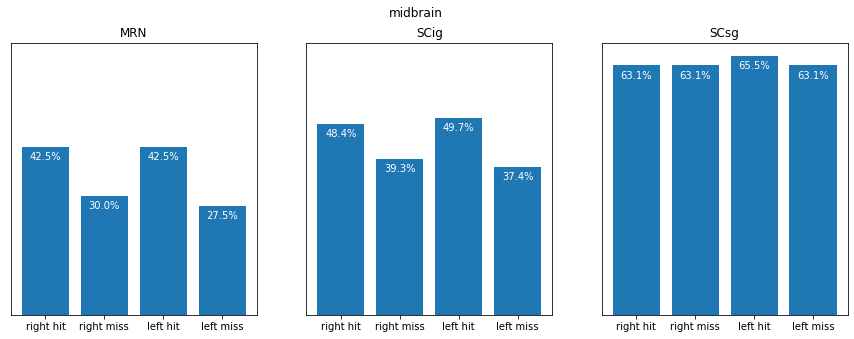

In [ ]:
plotPrelimFig_single(session = 23, region_num = 4, percentList = percentList)

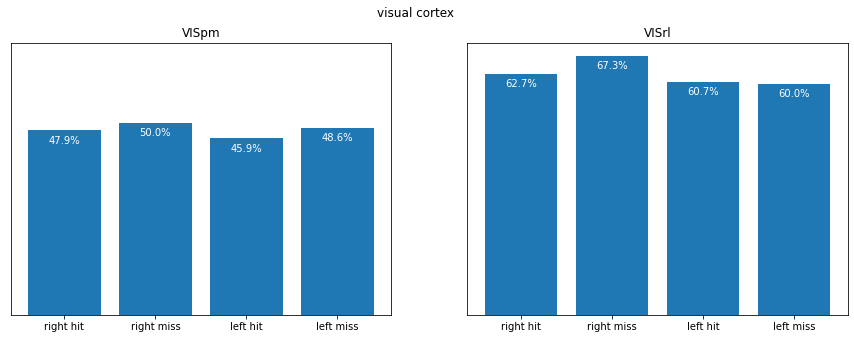

In [ ]:
# initialize 
session = 23
region_num = 0

structures = np.unique(brainAreas[session][brainRegions[session]==region_num])
structures

percentList = [] # list of percents for each structure

for structure in structures:
  n_comp, percent, components = generatePCA(23, single_region=True, structure = structure)
  percentList.append(percent)

plotPrelimFig_single(session = 23, region_num = 0, percentList = percentList, title = 'visual cortex')

1. PCA over a whole cortical region(s)

In [ ]:
n_comp, percent, _ = generatePCA(12, regions = foreMid)

2. Plot data

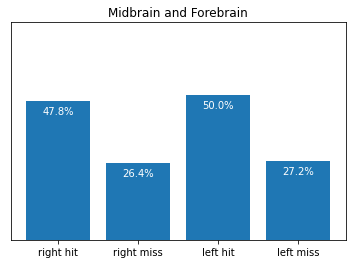

In [ ]:
plotPrelimFig(percent, title = "Midbrain and Forebrain")

## Merge data for all sessions

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
comp = []
perc = []

for sesh in sessions_w_visForeMid:
  n_comp, percent, _ = generatePCA(sesh, mid)
  comp.append(n_comp)
  perc.append(percent)

df = pd.DataFrame(perc)
df = df.T
df['side'] = ["left", "left", "right", "right"]
df['hits'] = ['hit', 'miss', 'hit', 'miss']

value = pd.melt(df, id_vars = ['side', 'hits'])

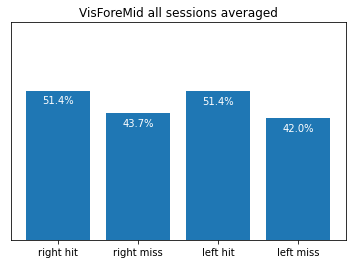

In [ ]:
# get the average percent of components needed for all trials
plotPrelimFig(df.mean(axis = 1), title = "VisForeMid all sessions averaged")

In [ ]:
trialTypes = [rightHit, rightMiss_left, rightMiss_nogo, leftHit, leftMiss_right, leftMiss_nogo]

In [ ]:
def prepANOVA_splitMiss(df):
  df = df.T
  df['side'] = ['right', 'right', 'right', 'left', 'left', 'left']
  df['hits'] = ['hit', 'miss_wrongSide', 'miss_nogo', 'hit', 'miss_wrongSide', 'miss_nogo']
  value = pd.melt(df, id_vars = ['side', 'hits'])

  return value

In [ ]:
def createANOVA(value):
  # Ordinary Least Squares (OLS) model
  # C(Hits):C(Side) represent interaction term
  model = ols('value ~ C(hits) + C(side) + C(hits):C(side)', data=value).fit()
  anova_tablem = sm.stats.anova_lm(model, typ=2)

  return anova_tablem

In [ ]:
def plotBoxplot(value, title = ""):
  sns.set(style="ticks", color_codes=True)
  m = sns.catplot(x="hits", y="value", hue="side", kind="box", data=value);
  m.set_axis_labels("Response","Linear Dimensionality Normalized Across Sessions")

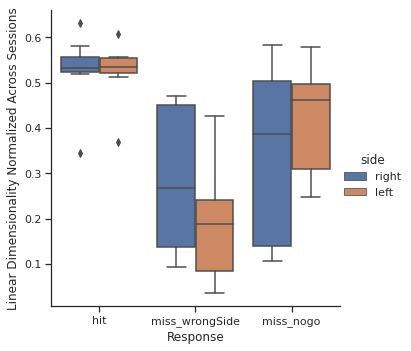

In [ ]:
perc, df = getData_splitMiss(mid)
value = prepANOVA_splitMiss(df)
plotBoxplot(value)

In [ ]:
createANOVA(value)

,sum_sq,df,F,PR(>F)
C(hits),0.653648,2.0,17.621145,0.000003
C(side),0.000763,1.0,0.041156,0.840217
C(hits):C(side),0.053933,2.0,1.453922,0.245171
Residual,0.778985,42.0,NaN,NaN


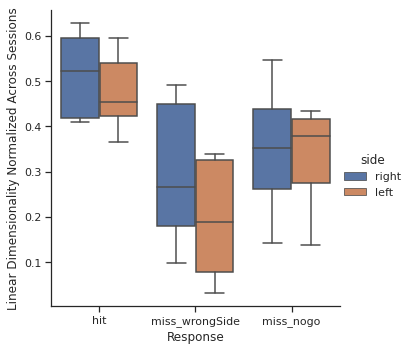

In [ ]:
plotBoxplot(value)

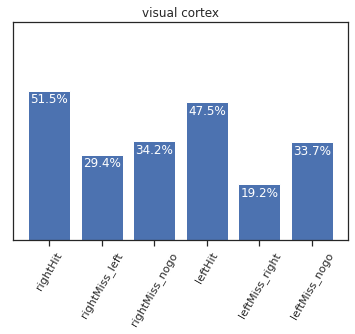

In [ ]:
perc, df = getData_splitMiss(vis)
plot_splitMiss(perc, "visual cortex")

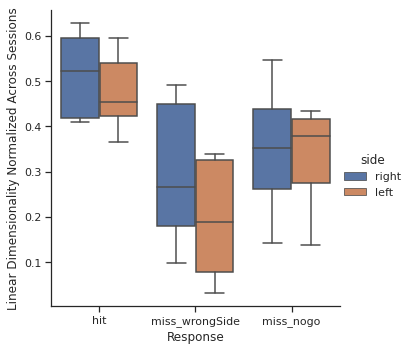

In [ ]:
value = prepANOVA_splitMiss(df)
plotBoxplot(value)

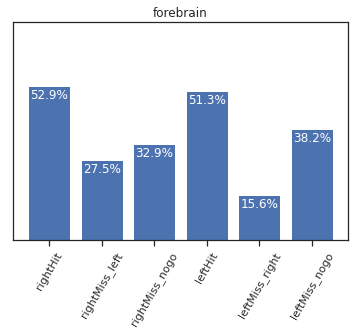

In [ ]:
perc, df = getData_splitMiss(fore)
plot_splitMiss(perc, "forebrain")

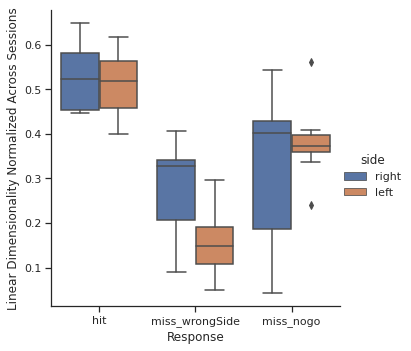

In [ ]:
value = prepANOVA_splitMiss(df)
plotBoxplot(value)

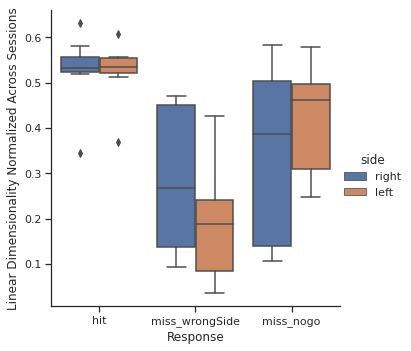

In [ ]:
# plot data for mid
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
m = sns.catplot(x="hits", y="value", hue="side", kind="box", data=value);
m.set_axis_labels("Response","Linear Dimensionality Normalized Across Sessions")

In [ ]:
# anova and plot for forebrain
comp = []
perc = []

for sesh in sessions_w_visForeMid:
  n_comp, percent, _ = generatePCA(sesh, fore)
  comp.append(n_comp)
  perc.append(percent)

df = pd.DataFrame(perc)
df = df.T
df['side'] = ["left", "left", "left", "right", "right", "right"]
df['hits'] = ['hit', 'miss', 'hit', 'miss', "hit", "miss"]

value = pd.melt(df, id_vars = ['side', 'hits'])
#value

# Ordinary Least Squares (OLS) model
# C(Hits):C(Side) represent interaction term
model = ols('value ~ C(hits) + C(side) + C(hits):C(side)', data=value).fit()
anova_tablef = sm.stats.anova_lm(model, typ=2)
anova_tablef


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: ignored

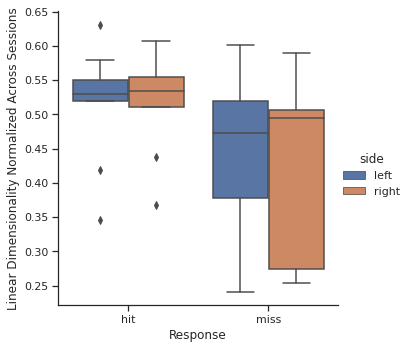

In [ ]:

f = sns.catplot(x="hits", y="value", hue="side", kind="box", data=value);
f.set_axis_labels("Response","Linear Dimensionality Normalized Across Sessions")

In [ ]:
# anova and plot for forebrain

comp = []
perc = []

for sesh in sessions_w_visForeMid:
  n_comp, percent, _ = generatePCA(sesh, vis)
  comp.append(n_comp)
  perc.append(percent)

df = pd.DataFrame(perc)
df = df.T
df['side'] = ["left", "left", "right", "right"]
df['hits'] = ['hit', 'miss', 'hit', 'miss']

value = pd.melt(df, id_vars = ['side', 'hits'])
#value

# Ordinary Least Squares (OLS) model
# C(Hits):C(Side) represent interaction term
model = ols('value ~ C(hits) + C(side) + C(hits):C(side)', data=value).fit()
anova_tablev = sm.stats.anova_lm(model, typ=2)
anova_tablev


IndexError: ignored

In [ ]:
v = sns.catplot(x="hits", y="value", hue="side", kind="box", data=value);
v.set_axis_labels("Response","Linear Dimensionality Normalized Across Sessions")

In [ ]:
comp = []
perc = []

for sesh in sessions_w_visForeMid:
  n_comp, percent, _ = generatePCA(sesh, visMid)
  comp.append(n_comp)
  perc.append(percent)

df = pd.DataFrame(perc)
df = df.T
df['side'] = ["left", "left", "right", "right"]
df['hits'] = ['hit', 'miss', 'hit', 'miss']

value = pd.melt(df, id_vars = ['side', 'hits'])
#value

# Ordinary Least Squares (OLS) model
# C(Hits):C(Side) represent interaction term
model = ols('value ~ C(hits) + C(side) + C(hits):C(side)', data=value).fit()
anova_tablevm = sm.stats.anova_lm(model, typ=2)
anova_tablevm

IndexError: ignored

In [ ]:
vm = sns.catplot(x="hits", y="value", hue="side", kind="box", data=value);
vm.set_axis_labels("Response","Linear Dimensionality Normalized Across Sessions")

In [ ]:
comp = []
perc = []

for sesh in sessions_w_visForeMid:
  n_comp, percent, _ = generatePCA(sesh, visFore)
  comp.append(n_comp)
  perc.append(percent)

df = pd.DataFrame(perc)
df = df.T
df['side'] = ["left", "left", "right", "right"]
df['hits'] = ['hit', 'miss', 'hit', 'miss']

value = pd.melt(df, id_vars = ['side', 'hits'])
#value

# Ordinary Least Squares (OLS) model
# C(Hits):C(Side) represent interaction term
model = ols('value ~ C(hits) + C(side) + C(hits):C(side)', data=value).fit()
anova_tablevf = sm.stats.anova_lm(model, typ=2)
anova_tablevf

In [ ]:
vf = sns.catplot(x="hits", y="value", hue="side", kind="box", data=value);
vf.set_axis_labels("Response","Linear Dimensionality Normalized Across Sessions")

In [ ]:
comp = []
perc = []

for sesh in sessions_w_visForeMid:
  n_comp, percent, _ = generatePCA(sesh, foreMid)
  comp.append(n_comp)
  perc.append(percent)

df = pd.DataFrame(perc)
df = df.T
df['side'] = ["left", "left", "right", "right"]
df['hits'] = ['hit', 'miss', 'hit', 'miss']

value = pd.melt(df, id_vars = ['side', 'hits'])
#value

# Ordinary Least Squares (OLS) model
# C(Hits):C(Side) represent interaction term
model = ols('value ~ C(hits) + C(side) + C(hits):C(side)', data=value).fit()
anova_tablefm = sm.stats.anova_lm(model, typ=2)
anova_tablefm

In [ ]:
fm = sns.catplot(x="hits", y="value", hue="side", kind="box", data=value);
fm.set_axis_labels("Response","Linear Dimensionality Normalized Across Sessions")

In [ ]:
#visForeMid = [0, 3, 4] # indeces for visual, forebrain (sans vis), and midbrain respectively
comp = []
perc = []

for sesh in sessions_w_visForeMid:
  n_comp, percent, _ = generatePCA(sesh, visForeMid)
  comp.append(n_comp)
  perc.append(percent)

df = pd.DataFrame(perc)
df = df.T
df['side'] = ["left", "left", "right", "right"]
df['hits'] = ['hit', 'miss', 'hit', 'miss']

value = pd.melt(df, id_vars = ['side', 'hits'])
#value

# Ordinary Least Squares (OLS) model
# C(Hits):C(Side) represent interaction term
model = ols('value ~ C(hits) + C(side) + C(hits):C(side)', data=value).fit()
anova_tablevfm = sm.stats.anova_lm(model, typ=2)
anova_tablevfm

In [ ]:
vfm = sns.catplot(x="hits", y="value", hue="side", kind="box", data=value);
vfm.set_axis_labels("Response","Linear Dimensionality Normalized Across Sessions")

Smol dive into the midbrain

In [ ]:
# which midbrain structures are we analyzing and how many neurons were recorded?
structures, counts = np.unique(brainAreas[23][brainRegions[23] == 4], return_counts=True)
for i in range(len(structures)):
  print("{} contains {} neurons".format(structures[i], counts[i]))

Bad practice revamping an old function. Don't judge

In [ ]:
def generatePCA_single(session, structure, varThreshold = 0.9):
  '''
  Inputs:
  session (int): index that corresponds to session number
  regions (int): integer that corresponds to region from brainRegions
  varThreshold (float): desired cumulative percent of variance explained

  Outputs:
  Each list outputs data for rightHit, rightMiss, leftHit, and leftMiss respectively
  numComp (list): number of components needed to explain up to varThreshold
  percent (list): percent of components needed to explain up to varThreshold
  components (list): components matrix
  '''
  n_comp = []
  percent = [] 
  components = []

  for trial in trialTypes:
    # get spike data
    dat = trial[session][brainAreas[session] == structure]

    # prep for PCA by reshaping into a 2D matrix and centering the data
    dat_reshape = np.reshape(dat, (len(dat), -1))
    dat_meaned = dat_reshape - np.mean(dat_reshape)

    # fit PCA 
    pca_model = PCA()
    pca_model.fit(dat_meaned.T)

    # how many components were needed to explain 90% of the variance in the data?
    preExplVar = pca_model.explained_variance_ratio_ 
    explVar = np.cumsum(preExplVar)

    numComponents = np.sum(explVar <= varThreshold)
    n_comp.append(numComponents)

    # how does this compare to the total number of components? 
    percentOfTotal = numComponents / len(dat)
    percent.append(percentOfTotal)

    # save principal components (organized by highest explained var to least)
    W = pca_model.components_
    components.append(W)

  return n_comp, percent, components

Next: Get subplots set

In [ ]:
# which forebrain structures are we analyzing and how many neurons were recorded?
structures, counts = np.unique(brainAreas[23][brainRegions[23] == 3], return_counts=True)
for i in range(len(structures)):
  print("{} contains {} neurons".format(structures[i], counts[i]))

RSP contains 181 neurons


In [ ]:
# which visual cortex structures are we analyzing and how many neurons were recorded?
structure, counts = np.unique(brainAreas[23][brainRegions[23] == 0], return_counts=True)
for i in range(len(structure)):
  print("{} contains {} neurons".format(structure[i], counts[i]))

VISpm contains 146 neurons
VISrl contains 150 neurons


### Plot PCA components for each region

In [ ]:
visList = [visRHComps, visRMComps, visLHComps, visLMComps]
midList = [midRHComps, midRMComps, midLHComps, midLMComps]
foreList = [foreRHComps, foreRMComps, foreLHComps, foreLMComps]

allRegions = [visList, midList, foreList]

fig, ax = plt.subplots(3, 4, figsize = (10, 10), sharey = True, sharex = True)

for region in range(len(allRegions)):
  for trialType in range(len(allRegions[region])):
    ax[region][trialType].hist(allRegions[region][trialType])

'''
next: figure out how best to label regions and trial types
if ax[region] == 0: label trial
if ax[:][trialType] == 0: label regions
'''


NameError: ignored

# Next step: move into the PCA

7.22.20

In [ ]:
#PCA for all brain data 
from sklearn.decomposition import PCA #import pca from Sklearn library

def pcaForArea (choiceSpikes,brainRegions, roi = -1,numberComponents = 3000, varThreshold = 0.9):
  '''
  Function to run PCA on session-separated spike data, looking at neurons within a particular 
  region. It runs a large PCA, determines the # components needed to reach a 
  variance explained threshold. It returns, for each session, the # components
  to hit the variance explained threshold. 
  Time bins in trials are reshaped to be a continuous train for each neuron.

  Inputs: 
    choiceSpikes (list of 3D arrays): spiking data for a choice. Each item in the list is a session,
                                     organized as neuron x trial x time bin; e.g. right hit, right miss
    brainRegions (list of 1D arrays): brain regions for each neuron in a list item in choiceSpikes
    roi (integer): number associated with the region of interest in brainRegions. Default -1 (whole brain)
    numberComponents (integer): the number of components to run in the large PCA. Default, 500
    varThreshold (float): the proportion of variance you'd like to explain with the PCA components. Default 0.9

  Outputs:
    holdComponents (list of 2D arrays): component weights from PCA for model
    maxCompsSessions (list of integers): for each session, the # components that explain 90% of variance.
    maxVarExplained (list of integers): actual variance explained-- may be less than threshold if components are low. 


  '''
  #initialize output lists
  holdComponents = []
  maxCompsSessions = []
  maxVarExplained = []

  #print(len(choiceSpikes), end = ": ")

  # #Time course: start of stimulus interval to the end.
  # #time course was variable & linked to stimulus onset. Termination at response. 
  for i in range(len(choiceSpikes)):  #loop through each session. 
  #we do NOT need to loop through choiceSpikes because this contains 39 sessions. But not all sessions have recordings 
  #from each of the brain areas that we are intersted in (i.e. visual, mid, forebrain )
  # July 24th, SC & AT : loop over sessions_w_visForeMid
    #print(len(choiceSpikes))
    #prepare data for PCA
    datHolder = choiceSpikes[i] #get a single session
    
    #now cut down to just region of interest. 
    if roi > -1:
      datHolder = datHolder[brainRegions[i]==roi,:,:] #Doesn't make sense. 

    #First: # components can't be >= the # of neurons. 
    #current_numberComponents = min(numberComponents,datHolder.shape[0]-1)

    #print(current_numberComponents)
    if datHolder.shape[0]<1:
      continue

    #Is the region of interest recorded in the session? If no, pass this iteration.
    #if (roi >=0 & np.count_nonzero(brainRegions[i]==roi)<=0):
    #  print("There are no neurons from the roi %s in session %s" % (roi, i))
    #  continue

    #print(datHolder.shape)

    #reshape long. Keep all time bins, so just a long 2nd dimension across trials.
    dat_reshape = np.reshape(datHolder, (-1,datHolder.shape[1]*datHolder.shape[2]))
    #print(datHolder.shape[1],datHolder.shape[2])
    #print(dat_reshape.shape)

    dat_meaned = dat_reshape - np.mean(dat_reshape)
    #print(dat_meaned)

    #Fit PCA 
    pca_model = PCA() #w/ components. Set max manually. 
    pca_model.fit(dat_meaned.T) #fit data

    #pick appropriate number components
    preExplVar = pca_model.explained_variance_ratio_ #gets % var explained by each component
    explVar = np.cumsum(preExplVar) # cumulative sum of explained variance
    if explVar[0] <varThreshold:
      componentMax = np.argmax(np.where(explVar<= varThreshold)) #get component index such that 90% variance is explained.
      maxCompsSessions.append(componentMax+1) #since it's an index, add 1 to the value.
      maxVarExplained.append(explVar[componentMax]) #get var explained, in case it's not at threshold
    else:
      maxCompsSessions.append(1)
      maxVarExplained.append(explVar[0])
    #run updated PCA using the # components we want. 
    #pca_correct = PCA(n_components=componentMax+1).fit(dat_meaned.T) #since this indexes from 1, I need to add that back on. 

    #update our components holder to keep these components
    W = pca_model.components_
    holdComponents.append(W) #add new component matrix.

    #let us know where you are. 
    print(i+1, end = " ")

  return holdComponents, maxCompsSessions, maxVarExplained
  



In [ ]:
#run on whole brain
# we need to take into consideration those that were filtered out. i.e. use 
#only the sessions from sessions_w_visForeMid rather than from brainRegions
allRHWMat, allRHComps, allRHVar = pcaForArea(rightHit,brainRegions) #right hits
allRMWMat, allRMComps, allRMVar = pcaForArea(rightMiss,brainRegions) #right misses

allLHWMat, allLHComps, allLHVar = pcaForArea(leftHit,brainRegions) #left hits
allLMWMat, allLMComps, allLMVar = pcaForArea(leftMiss,brainRegions) #left misses

In [ ]:
from matplotlib import pyplot as plt
print(statistics.mean(visRHComps))
plt.hist(visRHComps)

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




In [ ]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
#@title basic plots of population average
from matplotlib import pyplot as plt
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response>=0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

In [ ]:
# # groupings of brain regions
# regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
# brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
#                 ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
#                 ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
#                 ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
#                 ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
#                 ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
#                 ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
#                 ]

# nareas = 4 # only the top 4 regions are in this particular mouse
# NN = len(dat['brain_area']) # number of neurons
# barea = nareas * np.ones(NN, ) # last one is "other"
# for j in range(nareas):
#   barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

# starting to work on our project


In [ ]:
#@title plots by brain region and visual conditions
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0, vis_right>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0, vis_right>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


In [ ]:
#@title plots by brain region and response type
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  if np.sum(barea==j)==0:
    continue
  plt.plot(1/dt * dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
  plt.plot(1/dt * dat['spks'][barea==j][:,response>0].mean(axis=(0,1)))
  plt.plot(1/dt * dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
 
  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')


In [ ]:
#@title top PC directions from stimulus + response period, with projections of the entire duration
from sklearn.decomposition import PCA 

droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

In [ ]:
#@title The top PCs capture most variance across the brain. What do they care about? 
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2,len(pc_10ms)+1,j+1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))
   
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)
  
  plt.plot(pc1[response>0, :].mean(axis=0))  
  plt.plot(pc1[response<0, :].mean(axis=0))
  plt.plot(pc1[response==0, :].mean(axis=0))

  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

In [ ]:
#@title now sort all trials by response latency and see if the PCs care about that.
from scipy.stats import zscore

isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2,)
  ax.set(xlabel = 'binned time', ylabel = 'trials sorted by latency')
  plt.title('PC %d'%j)

In [ ]:
#@title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10) 

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2)
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')


In [ ]:
# plot the LFP

is_correct = np.sign(response)==np.sign(vis_left-vis_right)
isort = np.argsort(-is_correct.astype('float32') + response/10) # sort by correct, and then by response

nwrong = np.sum(is_correct)
plt.figure(figsize=(20,6))
for j in range(len(dat['lfp'])):
  ax = plt.subplot(2,6,j+1)
  plt.imshow(dat['lfp'][j, isort], cmap = 'bwr', vmax = 50, vmin=-50, aspect='auto')
  plt.title('Area %s'%dat['brain_area_lfp'][j])
  
  plt.plot([0, NT], [nwrong, nwrong], 'r')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  


In [ ]:
# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1,5,1)
plt.plot(dat['pupil'][0, :].mean(0));
ax.set(ylabel='pupil area', xlabel = 'binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1,5,2)
plt.plot(dat['wheel'][0, response>0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Left choices');

ax = plt.subplot(1,5,3)
plt.plot(dat['wheel'][0, response<0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Right choices');

ax = plt.subplot(1,5,4)
plt.plot(dat['wheel'][0, response==0].mean(0));
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='No go choices');


In [ ]:
# plot the spike waveforms for some neurons. Sometimes these can tell us what cell type the neuron is 
# (i.e. fast spiking interneurons have short waveforms)

for j in range(7):
  ax = plt.subplot(1,7,j+1)
  kk = 140 + j * 50
  wav = dat['waveform_w'][kk] @ dat['waveform_u'][kk]
  plt.plot(wav)
  ax.set(xlabel = 'time samples', title ='unit %d'%kk, ylabel = 'normalized units')

In [ ]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0, vis_right_p>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0 , vis_right_p==0)].mean(axis=(0,1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0 , vis_right_p==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0, vis_right_p>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')

1. for one mouse
- loop through (spike data) brain regions, paired in the order found in steinmetz
- pca of two brain regions
- add up pca components and predict task performance (correct / incorrect)


In [ ]:
# subtracting pairwise stimulus activity for each neuron and trial, trial by trial
# use residuals to do the analysis

#VISam = dat['spks'][dat['brain_area'] == 'VISam']
#VISp = dat['spks'][dat['brain_area'] == 'VISp']
#droller = np.concatenate((VISam, VISp), axis=0)

from sklearn.decomposition import PCA 

# take first 1.6s time bins
dat_reshape = np.reshape(dat['spks'][:,:,51:-1 ], (len(dat['spks']),-1)) 

# mean score
dat_meaned = dat_reshape - np.mean(dat_reshape, axis=1)[:, np.newaxis]

# set up a loop to find optimal component number

num_comp = 5
# run pca
model = PCA(n_components = num_comp).fit(dat_meaned.T)

# take model_components
W = model.components_

# reconstructing the data scores
#pc_10ms = W @ np.reshape(dat['spks'], (len(dat_meaned),-1))
pc_10ms = W @ dat['spks'].mean(axis=2)
#pc_10ms = np.reshape(pc_10ms, (num_comp, dat['spks'].shape[1], dat['spks'].shape[2]))

In [ ]:
pc_10ms = np.reshape(pc_10ms, (num_comp, dat['spks'].shape[1], dat['spks'].shape[2]))

In [ ]:
import matplotlib.pyplot as plt 
print(plt.plot(pc_10ms[0, :], color='r'))
print(plt.plot(pc_10ms[1, :], color='orange'))
print(plt.plot(pc_10ms[2, :], color='yellow'))
print(plt.plot(pc_10ms[3, :], color='green'))
print(plt.plot(pc_10ms[4, :], color='purple'))

In [ ]:
print(plt.plot(dat['feedback_type']))

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
kf = KFold(n_splits=2)
coef = []
accuracy = []

X = pc_10ms.T
y = dat['feedback_type']
model = LogisticRegression()
for train_index, test_index in kf.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  model.fit(X_train, np.ravel(y_train))
  coef.append(model.coef_[0])
  accuracy.append (model.score(X_test, y_test))
    
print('mean accuracy:', round(pd.DataFrame(accuracy).mean()[0], 5))
#print('significantly greater than chance 50%, p-value=', round(binom_test(pd.DataFrame(accuracy).mean()*len(X), len(X), .5, alternative='greater'), 5))
#print(cross_val_score(model, pc_10ms.T, dat['feedback_type'], cv=20))


In [ ]:
coef

In [ ]:
#@title The top PCs capture most variance across the brain. What do they care about? 
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2,len(pc_10ms)+1,j+1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))
   
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)
  
  plt.plot(pc1[response>0, :].mean(axis=0))  
  plt.plot(pc1[response<0, :].mean(axis=0))
  plt.plot(pc1[response==0, :].mean(axis=0))

  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

In [ ]:
#@title now sort all trials by response latency and see if the PCs care about that.
from scipy.stats import zscore

isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2,)
  ax.set(xlabel = 'binned time', ylabel = 'trials sorted by latency')
  plt.title('PC %d'%j)

In [ ]:
# Perform PCA on the data matrix X
#score, evectors, evals = pca(droller_meaned.T)
# Plot the data projected into the new basis
with plt.xkcd():
  plot_data_new_basis(pc_10ms)

In [ ]:
plot_eigenvalues(evals)

In [ ]:
# calculate the variance explained
variance_explained = get_variance_explained(evals)
with plt.xkcd():
  plot_variance_explained(variance_explained)

In [ ]:
def plot_variance_explained(variance_explained):
  """
  Plots eigenvalues.

  Args:
    variance_explained (numpy array of floats) : Vector of variance explained
                                                 for each PC

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
           '--k')
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  plt.show()



def get_variance_explained(evals):
  """
  Plots eigenvalues.

  Args:
    (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """

  # cumulatively sum the eigenvalues
  csum = np.cumsum(evals)
  # normalize by the sum of eigenvalues
  variance_explained = csum / np.sum(evals)

  return variance_explained

def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X
  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
  Returns:
    (numpy array of floats)   : Covariance matrix
  """

  # Subtract the mean of X
  X = X - np.mean(X, 0)
  # Calculate the covariance matrix (hint: use np.matmul)
  cov_matrix = cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)

  return cov_matrix


variance_1 = 1
variance_2 = 1
corr_coef = 0.8

np.random.seed(2020)  # set random seed
cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)
print(cov_matrix)

X = get_data(cov_matrix)
sample_cov_matrix = get_sample_cov_matrix(X)
print(sample_cov_matrix)


def pca(X):
  """
  Performs PCA on multivariate data.
  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
  Returns:
    (numpy array of floats)   : Data projected onto the new basis
    (numpy array of floats)   : Vector of eigenvalues
    (numpy array of floats)   : Corresponding matrix of eigenvectors
  """

  # Subtract the mean of X
  X = X - np.mean(X, axis=0)
  # Calculate the sample covariance matrix
  cov_matrix = get_sample_cov_matrix(X)
  # Calculate the eigenvalues and eigenvectors
  evals, evectors = np.linalg.eigh(cov_matrix)
  # Sort the eigenvalues in descending order
  evals, evectors = sort_evals_descending(evals, evectors)
  # Project the data onto the new eigenvector basis
  score = change_of_basis(X, evectors)

  return score, evectors, evals

In [ ]:
def plot_eigenvalues(evals):
  """
  Plots eigenvalues.

  Args:
      (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """
  plt.figure(figsize=(4, 4))
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  plt.xticks(np.arange(1, len(evals) + 1))
  plt.ylim([0, .6])


def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    : Vector of eigenvalues
    evectors (numpy array of floats) : Corresponding matrix of eigenvectors
                                        each column corresponds to a different
                                        eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]
  return evals, evectors


def plot_data(X):
  """
  Plots bivariate data. Includes a plot of each random variable, and a scatter
  scatter plot of their joint activity. The title indicates the sample
  correlation calculated from the data.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(X[:, 0], color='k')
  plt.ylabel('Neuron 1')
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(X[:, 1], color='k')
  plt.xlabel('Sample Number (sorted)')
  plt.ylabel('Neuron 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(X[:, 0], X[:, 1], '.', markerfacecolor=[.5, .5, .5],
           markeredgewidth=0)
  ax3.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(X[:, 0], X[:, 1])[0, 1]))
  plt.show()


def get_data(cov_matrix):
  """
  Returns a matrix of 1000 samples from a bivariate, zero-mean Gaussian

  Note that samples are sorted in ascending order for the first random
  variable.

  Args:
    var_1 (scalar)                     : variance of the first random variable
    var_2 (scalar)                     : variance of the second random variable
    cov_matrix (numpy array of floats) : desired covariance matrix

  Returns:
    (numpy array of floats)            : samples from the bivariate Gaussian,
                                          with each column corresponding to a
                                          different random variable
  """

  mean = np.array([0, 0])
  X = np.random.multivariate_normal(mean, cov_matrix, size=1000)
  indices_for_sorting = np.argsort(X[:, 0])
  X = X[indices_for_sorting, :]
  return X


def calculate_cov_matrix(var_1, var_2, corr_coef):
  """
  Calculates the covariance matrix based on the variances and
  correlation coefficient.

  Args:
    var_1 (scalar)         :  variance of the first random variable
    var_2 (scalar)         :  variance of the second random variable
    corr_coef (scalar)     :  correlation coefficient

  Returns:
    (numpy array of floats) : covariance matrix
  """
  cov = corr_coef * np.sqrt(var_1 * var_2)
  cov_matrix = np.array([[var_1, cov], [cov, var_2]])
  return cov_matrix


def define_orthonormal_basis(u):
  """
  Calculates an orthonormal basis given an arbitrary vector u.

  Args:
    u (numpy array of floats) : arbitrary 2D vector used for new basis

  Returns:
    (numpy array of floats)   : new orthonormal basis columns correspond to
                                basis vectors
  """

  u = u / np.sqrt(u[0] ** 2 + u[1] ** 2)
  w = np.array([-u[1], u[0]])
  W = np.column_stack((u, w))
  return W


def plot_data_new_basis(Y):
  """
  Plots bivariate data after transformation to new bases. Similar to plot_data
  but with colors corresponding to projections onto basis 1 (red) and
  basis 2 (blue).
  The title indicates the sample correlation calculated from the data.

  Note that samples are re-sorted in ascending order for the first random
  variable.

  Args:
    Y (numpy array of floats) : Data matrix in new basis each column
                                corresponds to a different random variable

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=[8, 4])
  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax1.plot(Y[:, 0], 'r')
  plt.ylabel('Projection \n basis vector 1')
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.plot(Y[:, 1], 'b')
  plt.xlabel('Projection \n basis vector 1')
  plt.ylabel('Projection \n basis vector 2')
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(Y[:, 0], Y[:, 1], '.', color=[.5, .5, .5])
  ax3.axis('equal')
  plt.xlabel('Projection basis vector 1')
  plt.ylabel('Projection basis vector 2')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(Y[:, 0], Y[:, 1])[0, 1]))
  plt.show()


def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)
  return Y


def plot_basis_vectors(X, W):
  """
  Plots bivariate data as well as new basis vectors.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
    W (numpy array of floats) : Square matrix representing new orthonormal
                                basis each column represents a basis vector

  Returns:
    Nothing.
  """

  plt.figure(figsize=[4, 4])
  plt.plot(X[:, 0], X[:, 1], '.', color=[.5, .5, .5], label='Data')
  plt.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.plot([0, W[0, 0]], [0, W[1, 0]], color='r', linewidth=3,
           label='Basis vector 1')
  plt.plot([0, W[0, 1]], [0, W[1, 1]], color='b', linewidth=3,
           label='Basis vector 2')
  plt.legend()
  plt.show()